In [33]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import scipy.stats as st
import json
import seaborn as sns
import warnings
import re
from pathlib import Path
warnings.filterwarnings('ignore')

# Import API key
from api_keys import api_key


In [34]:
# Read in csv
oscar_data= pd.read_csv("Resources/oscar_data.csv")

In [35]:
base_url = "https://api.themoviedb.org/3/"

# Enter year
year = "2008"

startdate = f"{year}-01-01"
enddate = f"{year}-12-31"

all_movies_response = requests.get(f'{base_url}/discover/movie?include_adult=false&include_video=false&primary_release_date.gte={startdate}&primary_release_date.lte={enddate}&with_original_language=en&sort_by=vote_count.desc&api_key={api_key}').json()
total_pages = json.dumps(all_movies_response["total_pages"], indent=4, sort_keys=True)

In [36]:
responseid = {'Title' : [],'ID' : [], 'Vote Average' : [], 'Release Date' : []}

# Request from API for each month
for i in range(1,int(total_pages)//10):

# Request API for different pages
    all_movies_response = requests.get(f'{base_url}/discover/movie?include_adult=false&include_video=false&primary_release_date.gte={startdate}&primary_release_date.lte={enddate}&with_original_language=en&sort_by=vote_count.desc&api_key={api_key}&page={i}').json()
    total_pages = json.dumps(all_movies_response["total_pages"], indent=4, sort_keys=True)

    # Compiles results into a dictionary
    for j in range(len(all_movies_response["results"])):
        responseid['Title'].append(all_movies_response["results"][j]["title"])
        responseid['ID'].append(all_movies_response["results"][j]["id"])
        responseid['Vote Average'].append(all_movies_response["results"][j]["vote_average"])
        responseid['Release Date'].append(all_movies_response["results"][j]["release_date"])

In [37]:
# Converts dictionary into dataframe
moviedata = pd.DataFrame(responseid)

# Input string
moviedata['Release Date'] = pd.to_datetime(moviedata['Release Date'], utc=True)

# As Release Dates are text, they are first converted to UNIX 
moviedata['Release Date UNIX'] = moviedata['Release Date'].astype(np.int64)
moviedata = moviedata.sort_values("Release Date")

# Release Date is split into Day, Month and Year Columns
moviedata['Day'] = moviedata['Release Date'].dt.day
moviedata['Month'] = moviedata['Release Date'].dt.strftime('%b')
moviedata['Month Number'] = moviedata['Release Date'].dt.month
moviedata['Year'] = moviedata['Release Date'].dt.year
moviedata = moviedata.reset_index(drop=True)

moviedata

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year
0,Return,839321,7.267,2008-01-01 00:00:00+00:00,1199145600000000000,1,Jan,1,2008
1,20 Years After,14642,3.000,2008-01-01 00:00:00+00:00,1199145600000000000,1,Jan,1,2008
2,Hank and Mike,13119,5.538,2008-01-01 00:00:00+00:00,1199145600000000000,1,Jan,1,2008
3,Garden of Eden,8368,4.909,2008-01-01 00:00:00+00:00,1199145600000000000,1,Jan,1,2008
4,The Morgue,14209,4.656,2008-01-01 00:00:00+00:00,1199145600000000000,1,Jan,1,2008
...,...,...,...,...,...,...,...,...,...
715,Beethoven's Big Break,13955,5.200,2008-12-26 00:00:00+00:00,1230249600000000000,26,Dec,12,2008
716,Affinity,14766,5.800,2008-12-28 00:00:00+00:00,1230422400000000000,28,Dec,12,2008
717,Jack Hunter and the Quest for Akhenaten's Tomb,32895,6.400,2008-12-30 00:00:00+00:00,1230595200000000000,30,Dec,12,2008
718,Defiance,13813,6.844,2008-12-31 00:00:00+00:00,1230681600000000000,31,Dec,12,2008


In [38]:
# Nominated movies are added to a list by using the lambda function, and added to the moviedata dataframe as new columns
titles = moviedata['Title'].to_list()
noms = []

for movie in titles:
    mask = oscar_data[oscar_data.apply(lambda row: row.astype(str).str.contains(re.escape(str(movie)), case=False).any(), axis=1)]
    if mask.empty:
        noms.append("No")
        
    else:
        if mask['Year'].values[0] == year:
            noms.append("Yes")
        else:
            noms.append("No")

moviedata['Nominated'] = noms

moviedata.head()

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year,Nominated
0,Return,839321,7.267,2008-01-01 00:00:00+00:00,1199145600000000000,1,Jan,1,2008,No
1,20 Years After,14642,3.000,2008-01-01 00:00:00+00:00,1199145600000000000,1,Jan,1,2008,No
2,Hank and Mike,13119,5.538,2008-01-01 00:00:00+00:00,1199145600000000000,1,Jan,1,2008,No
3,Garden of Eden,8368,4.909,2008-01-01 00:00:00+00:00,1199145600000000000,1,Jan,1,2008,No
4,The Morgue,14209,4.656,2008-01-01 00:00:00+00:00,1199145600000000000,1,Jan,1,2008,No


In [39]:
# moviedata dataframe is reduced to only nominated movies
nominated_movies = moviedata.loc[moviedata['Nominated'] == "Yes"]

nominated_movies.head()

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year,Nominated
47,Trouble the Water,22319,6.760,2008-01-20 00:00:00+00:00,1200787200000000000,20,Jan,1,2008,Yes
84,In Bruges,8321,7.489,2008-02-08 00:00:00+00:00,1202428800000000000,8,Feb,2,2008,Yes
169,Frozen River,10183,6.655,2008-03-26 00:00:00+00:00,1206489600000000000,26,Mar,3,2008,Yes
200,Happy-Go-Lucky,10503,6.575,2008-04-18 00:00:00+00:00,1208476800000000000,18,Apr,4,2008,Yes
207,This Way Up,86118,7.270,2008-04-24 00:00:00+00:00,1208995200000000000,24,Apr,4,2008,Yes


In [40]:
# New column is added, value is based on whether the movie was released during, or outside of Oscar Season.
season = []

for row in nominated_movies['Month']:
    if row in ("Nov", "Dec"):
        season.append("Yes")
    else:
        season.append("No")

nominated_movies['Oscar Season'] = season

nominated_movies.head()

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year,Nominated,Oscar Season
47,Trouble the Water,22319,6.760,2008-01-20 00:00:00+00:00,1200787200000000000,20,Jan,1,2008,Yes,No
84,In Bruges,8321,7.489,2008-02-08 00:00:00+00:00,1202428800000000000,8,Feb,2,2008,Yes,No
169,Frozen River,10183,6.655,2008-03-26 00:00:00+00:00,1206489600000000000,26,Mar,3,2008,Yes,No
200,Happy-Go-Lucky,10503,6.575,2008-04-18 00:00:00+00:00,1208476800000000000,18,Apr,4,2008,Yes,No
207,This Way Up,86118,7.270,2008-04-24 00:00:00+00:00,1208995200000000000,24,Apr,4,2008,Yes,No


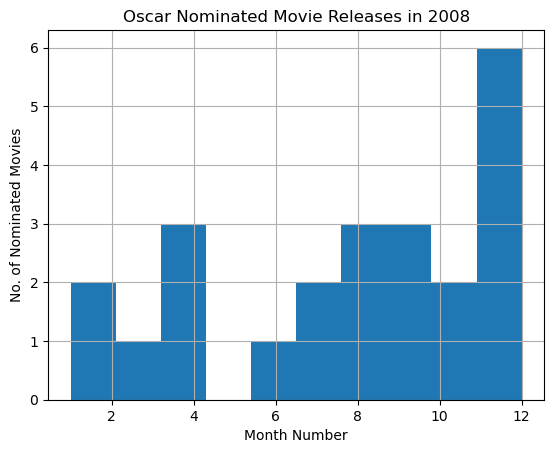

In [41]:
# Histogram of number of nominated movie releases per month in 2018
nominated_movies.hist(column='Month Number')

plt.xlabel('Month Number')
plt.ylabel('No. of Nominated Movies')

plt.title(f'Oscar Nominated Movie Releases in {year}')

# Histogram saved to output folder
plt.savefig(f'resources/output/{year}/histogram_{year}.png')

plt.show()

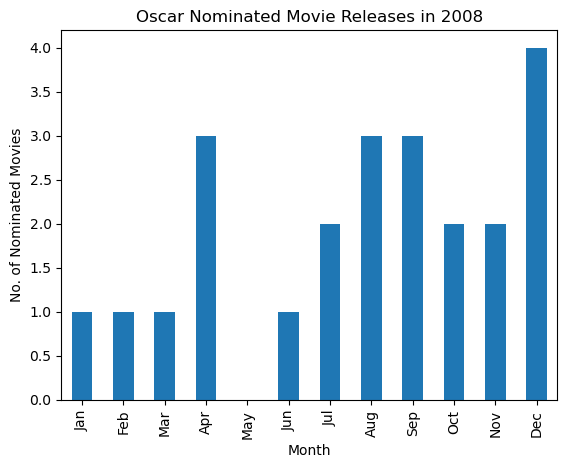

In [42]:
# Bar Chart of number of nominated movie releases per month in 2018
labels = moviedata["Month"].unique()
y_axis = nominated_movies["Month"].value_counts()
histodf = pd.DataFrame({'# of Oscar Nominated Movies released in month': y_axis}, index=labels)
ax = histodf['# of Oscar Nominated Movies released in month'].plot(kind="bar")

plt.xlabel("Month")
plt.ylabel("No. of Nominated Movies")

plt.title(f'Oscar Nominated Movie Releases in {year}')

# Bar chart saved to output folder
plt.savefig(f'resources/output/{year}/bar_chart_{year}.png')

plt.show()

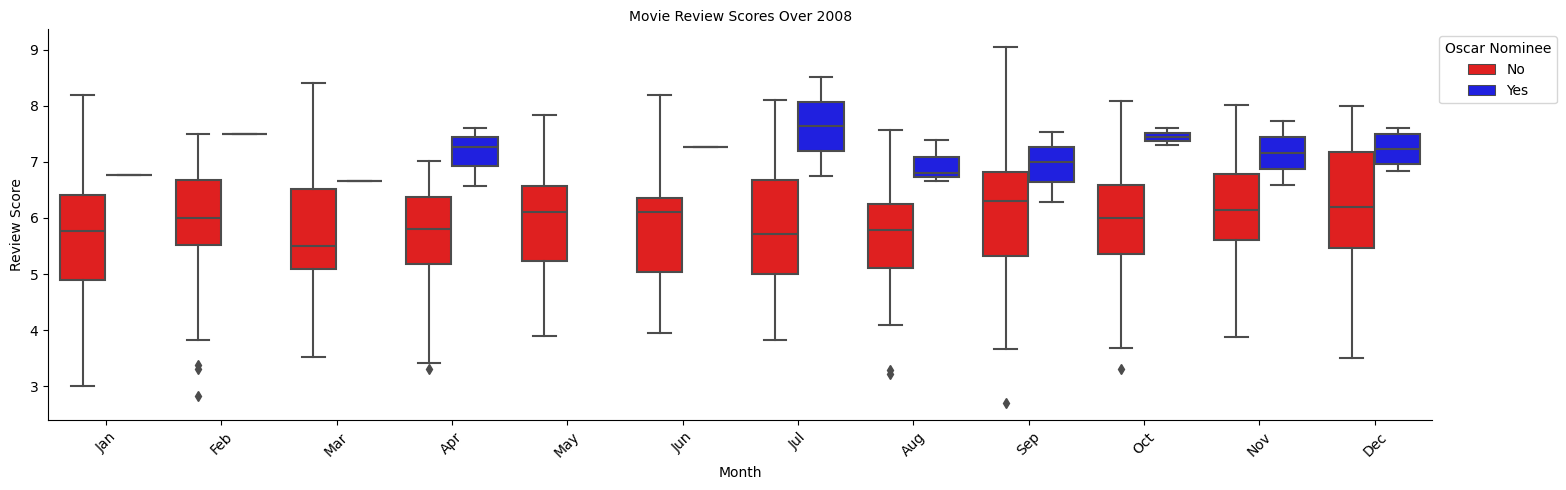

In [43]:
# Assuming your data is named 'moviedata' and contains columns 'Year', 'Month', 'Vote Average', and 'Nominated'

# Create the FacetGrid with year as the column variable
g = sns.FacetGrid(moviedata, col='Year', col_wrap=3, aspect=3, height=5)

# Map the boxplot onto the FacetGrid with custom palette
g.map(sns.boxplot, 'Month', 'Vote Average', 'Nominated', palette={'Yes': 'blue', 'No': 'red'})

# Add legend outside the plot area
plt.legend(title='Oscar Nominee', loc='upper left', bbox_to_anchor=(1, 1))

# Set titles, labels, and rotation
g.set_titles('Movie Review Scores Over {col_name}')
g.set_xlabels('Month')
g.set_ylabels('Review Score')
plt.xticks(rotation=45)

plt.savefig(f'resources/output/{year}/box_plot_{year}.png')

plt.tight_layout()
plt.show()


In [44]:
# Define function for linear regression
def linregplot(i,x,y,j,k):
    lr_slope, lr_int, lr_r, lr_p, lr_std_err = st.linregress(i[x],i[y])
    lr_fit = lr_slope * i[x] + lr_int
    title = str(f"{j} vs. {k}")
    
    plt.scatter(i[x],i[y], alpha= 0.8, edgecolors= 'black')
    plt.plot(i[x],lr_fit, 'r', label = 'y = {:.2f} + {:.2f}*x'.format(lr_slope, lr_int))
   
    plt.xticks(rotation=0)
    plt.xlabel(j)
    plt.ylabel(k)
    plt.title(title)
    plt.legend(loc = 'best')
    
    print(f"The r-value is: {lr_r}")

    # Scatterplot saved to output folder
    plt.savefig(f'resources/output/{year}/scatterplot_{year}.png')

    plt.show()

The r-value is: 0.1361528497543798


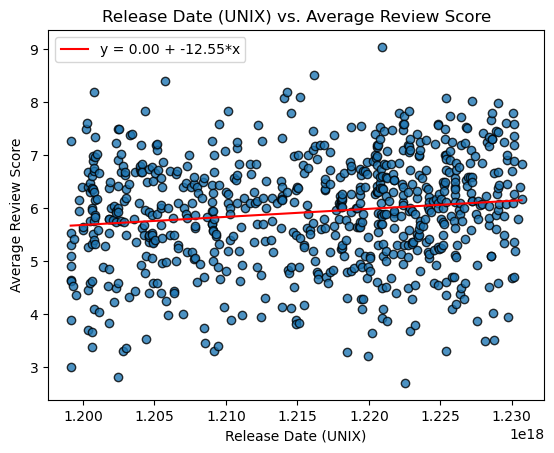

In [45]:
# Scatter Plot with linear regression
linregplot(moviedata, 'Release Date UNIX', 'Vote Average', 'Release Date (UNIX)', 'Average Review Score')

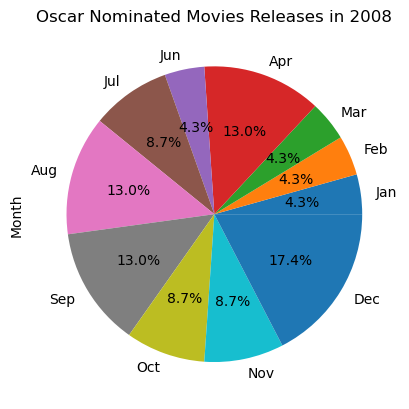

In [46]:
# Pie Chart of nominated movie releases per month in 2018
data_grouped_month = nominated_movies.groupby(["Month"])
labels_month = nominated_movies["Month"].unique()
bymonth = data_grouped_month["Month"].value_counts()

bymonth_df = pd.DataFrame({'Month': bymonth}, index=labels_month)

bymonth_df['Month'].plot(kind="pie", autopct='%.1f%%')

plt.title(f"Oscar Nominated Movies Releases in {year}")

# Save the plot
plt.savefig(f'resources/output/{year}/pie_chart_1_{year}.png')

plt.show()

Oscar Season is defined as November/December, 16.6% of the year


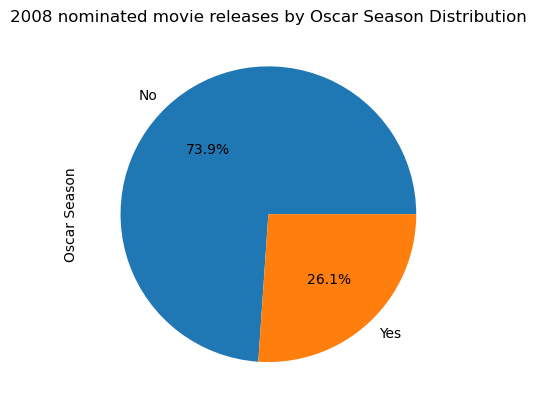

In [47]:
# Oscar Season Pie Chart
print("Oscar Season is defined as November/December, 16.6% of the year")

data_grouped_month = nominated_movies.groupby(["Oscar Season"])
labels_month = nominated_movies["Oscar Season"].unique()
bymonth = data_grouped_month["Oscar Season"].value_counts()

bymonth_df = pd.DataFrame({'Oscar Season': bymonth}, index=labels_month)

bymonth_df['Oscar Season'].plot(kind="pie", autopct='%.1f%%')

plt.title(f'{year} nominated movie releases by Oscar Season Distribution')

# Save the plot
plt.savefig(f'resources/output/{year}/pie_chart_2_{year}.png')

plt.show()

In [48]:
## Hypothesis Testing

# Subset the data into two groups: nominated and not nominated movies
nominated_movies = moviedata[moviedata['Nominated'] == 'Yes']['Vote Average']
not_nominated_movies = moviedata[moviedata['Nominated'] == 'No']['Vote Average']

# Define the null hypothesis: There is no significant difference in the average vote average between nominated and not nominated movies
# H0: μ1 = μ2 (where μ1 is the mean vote average of nominated movies and μ2 is the mean vote average of not nominated movies)
# Define the alternative hypothesis: There is a significant difference in the average vote average between nominated and not nominated movies
# H1: μ1 ≠ μ2
# This is a two-tailed test

# Perform a t-test
t_statistic, p_value = st.ttest_ind(nominated_movies, not_nominated_movies, equal_var=False)

# Set the significance level
alpha = 0.05

# Print the results and compare p-value to significance level

print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in the average vote average between nominated and not nominated movies.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in the average vote average between nominated and not nominated movies.")


# Export to text file
text_analysis = Path(f'resources/output/{year}/null_testing_{year}.txt')

with open (text_analysis,"w") as file:
    file.write(f'T-Statistic: {t_statistic}\n')
    file.write(f'P-Value: {p_value}\n')

    if p_value < alpha:
        file.write("Reject the null hypothesis. There is a significant difference in the average vote average between nominated and not nominated movies.")
    else:
        file.write("Fail to reject the null hypothesis. There is no significant difference in the average vote average between nominated and not nominated movies.")


T-Statistic: 11.239517902694846
P-Value: 6.231395452494119e-12
Reject the null hypothesis. There is a significant difference in the average vote average between nominated and not nominated movies.
